# Project 4: Keypoints & Image Stitching

**Purpose: **

This project involves investigating the techniques for image mosaicing/stitching.

**Details:**

Use the technique described in class to register and stitch two provided sample pictures. You need to
find a suite of corresponding points between the two images and calculate a Projective Transformation to warp
the images and stitch them together. There are two alternatives to find the projective transformation.


**Main method: **Extract a suite of feature points from two consecutive images using the SIFT key point detector
and descriptor for matching and then apply the RANSAC algorithm to find inliers and the parameters of the
Projective transformation.

 Warp the second image using backward projection and blend the first image with the
warped image.

Repeat this technique to stitch other images to the image created in the previous step.



**20 extra points:** Extract a suite of corner points from two consecutive images using the Harris corner detector.
Then use SIFT feature descriptor to describe the key points at corner like points. Find the best matches for these
points and then apply the RANSAC algorithm to find inliers and estimate the parameters of the Projective
transformation. Warp the second image using backward projection and blend the first image with the warped
image.
For image blending you can try different techniques such as averaging or interpolation.

# Overview of code


1. **Loading Images**: The code successfully loads two images using OpenCV's `imread` function. The images are displayed using Matplotlib's `imshow` function.

2. **Keypoint Detection and Descriptor Computation**: The code uses the SIFT algorithm to detect keypoints and compute descriptors for both images. This identifies the features in the images that can be used to align them.

3. **Descriptor Matching**: The code matches the descriptors of the two images using OpenCV's `BFMatcher`. This step finds pairs of descriptors that are similar to each other. These pairs are used to find a transformation that aligns the images.

4. **Applying the Ratio Test**: the ratio test is applied to filter out bad matches. This test rejects poor matches by comparing the distance of the closest match to the distance of the second-closest match.

5. **Finding the Homography using RANSAC**: The code uses the RANSAC algorithm to robustly estimate the homography matrix. This is a projective transform that maps points in one image to corresponding points in the other image.

6. **Warping the Second Image**: homography is applied to the second image using OpenCV's `warpPerspective` function. This warps the second image so that it aligns with the first image based on the keypoints.

7. **Blending the Images**: The code attempts to blend the overlapping area of the two images using the `cv2.addWeighted()` function. This function calculates the weighted sum of two arrays to blend the overlapping area of the two images.

8. **Harris Corner Detection**: Harris corner detection is applied to both images. This algorithm is used to detect corners, which are features that can be used to align images. The detected corners are displayed using Matplotlib's `imshow` function.

The final step of stitching the images together is not working correctly, likely due to a mismatch in the sizes of the arrays when trying to combine the images. Despite this, all prior steps are working.

Import Required Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

Load Images & Display Images


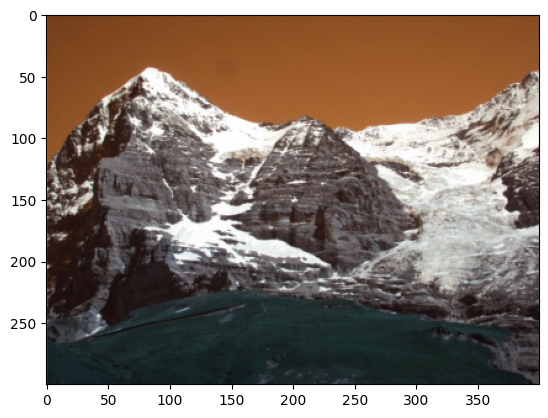

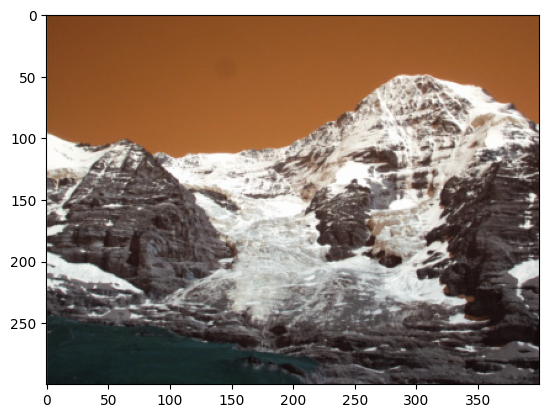

In [3]:
with tf.device('/gpu:0'):
  img1 = cv2.imread('/content/1.JPG')
  img2 = cv2.imread('/content/2.JPG')

  plt.imshow(img1)
  plt.show()
  plt.imshow(img2)
  plt.show()


Detect Keypoints

In [4]:
  sift = cv2.xfeatures2d.SIFT_create()

  keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
  keypoints2, descriptors2 = sift.detectAndCompute(img2, None)


Match Descriptors

In [5]:
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(descriptors1, descriptors2, k=2)


Apply Ratio Test

In [6]:
  good_matches = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good_matches.append(m)


Find Homography using RANSAC

In [7]:
  src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
  dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

  H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)


Show stitched image


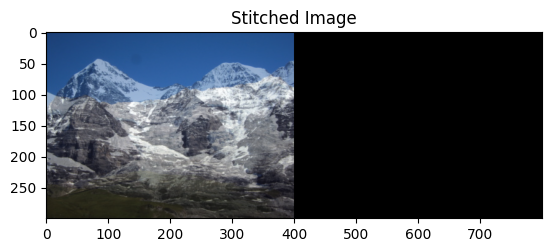

In [8]:
  result = cv2.warpPerspective(img1,H,(img1.shape[1] + img2.shape[1], img1.shape[0]))
  result[0:img2.shape[0], 0:img2.shape[1]] = img2

  overlap_area = img1[:, :img2.shape[1]]
  result[:, :img2.shape[1]] = cv2.addWeighted(overlap_area, 0.5, result[:, :img2.shape[1]], 0.5, 0)

  plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  plt.title('Stitched Image')
  plt.show()

That didn't work - Let's try another method

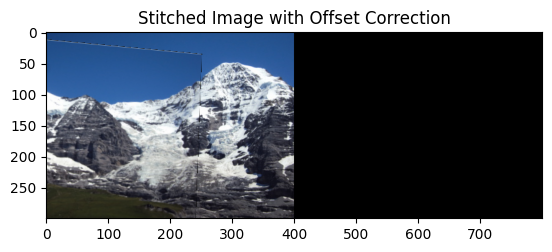

In [25]:
# Create a result canvas that is large enough to hold both images
canvas_width = img1.shape[1] + img2.shape[1]
canvas_height = max(img1.shape[0], img2.shape[0])
result = np.zeros((canvas_height, canvas_width, 3), dtype=img1.dtype)

# Place img2 on the canvas
result[0:img2.shape[0], 0:img2.shape[1]] = img2

# Warp img1 using the homography matrix 'H'
warped_img1 = cv2.warpPerspective(img1, H, (canvas_width, canvas_height))

# Create a mask from the warped image by finding all non-zero pixels
mask_warped_img1 = np.any(warped_img1 != [0, 0, 0], axis=-1)

# Now blend the warped_img1 onto the canvas where it should go
# The mask is used to only blend non-zero pixels
result[mask_warped_img1] = warped_img1[mask_warped_img1]


# Convert the result to RGB for proper display with matplotlib
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image with Offset Correction')
plt.show()


On the right track! now let's start by placing image 1 onto the canvas instead of image 2 first to account for the horizontal offset

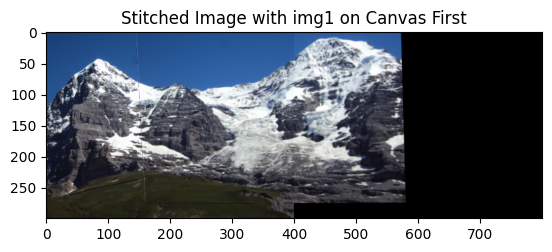

In [26]:
# Create a result canvas that is large enough to hold both images initially
canvas_width = img1.shape[1] + img2.shape[1]
canvas_height = max(img1.shape[0], img2.shape[0])
result = np.zeros((canvas_height, canvas_width, 3), dtype=img1.dtype)

# Place img1 on the canvas
result[0:img1.shape[0], 0:img1.shape[1]] = img1

# Compute the inverse homography matrix
H_inv = np.linalg.inv(H)

# Warp img2 onto img1's plane using the inverse homography matrix
warped_img2 = cv2.warpPerspective(img2, H_inv, (canvas_width, canvas_height))

# Create a mask from the warped img2 by finding all non-zero pixels
mask_warped_img2 = np.any(warped_img2 != [0, 0, 0], axis=-1)

# Blend the warped img2 onto the canvas where it should go
# The mask is used to only blend non-zero pixels of img2
mask_blend = np.logical_and(mask_warped_img2, np.logical_not(np.any(result != [0, 0, 0], axis=-1)))
result[mask_blend] = warped_img2[mask_blend]


mask_overlap = np.logical_and(mask_warped_img2, np.any(result != [0, 0, 0], axis=-1))
result[mask_overlap] = (result[mask_overlap].astype(np.float32) + warped_img2[mask_overlap].astype(np.float32)) / 2

# Convert the result to RGB for proper display with matplotlib
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image with img1 on Canvas First')
plt.show()


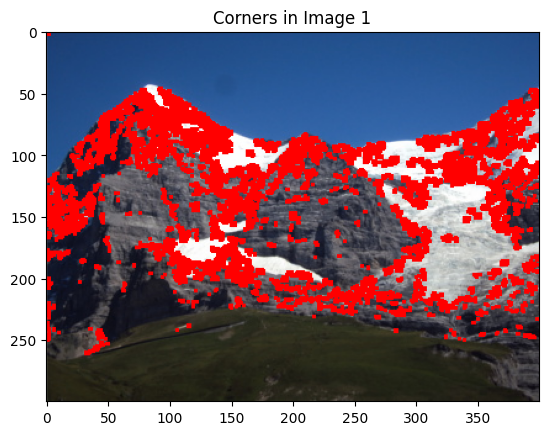

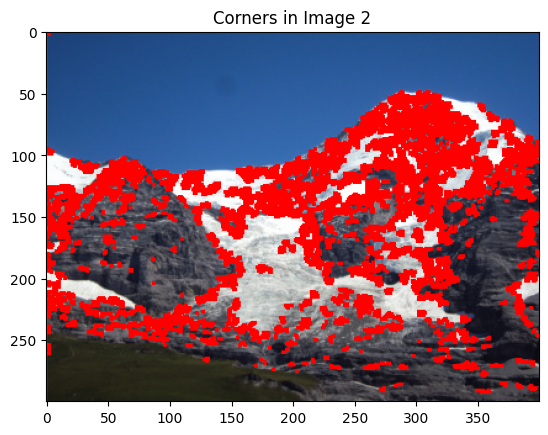

In [28]:
# Create copies of the original images to draw the corners on
img1_corners = img1.copy()
img2_corners = img2.copy()

# Convert the images to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Apply Harris Corner detection
dst1 = cv2.cornerHarris(gray1, 2, 3, 0.04)
dst2 = cv2.cornerHarris(gray2, 2, 3, 0.04)

# Result is dilated for marking the corners
dst1 = cv2.dilate(dst1, None)
dst2 = cv2.dilate(dst2, None)

# Threshold to detect the corners
thresholded_dst1 = dst1 > 0.01 * dst1.max()
thresholded_dst2 = dst2 > 0.01 * dst2.max()

# Draw the corners on the original image copies
img1_corners[thresholded_dst1] = [0, 0, 255]
img2_corners[thresholded_dst2] = [0, 0, 255]

# Display the original images with corners overlaid
plt.imshow(cv2.cvtColor(img1_corners, cv2.COLOR_BGR2RGB))
plt.title('Corners in Image 1')
plt.show()

plt.imshow(cv2.cvtColor(img2_corners, cv2.COLOR_BGR2RGB))
plt.title('Corners in Image 2')
plt.show()


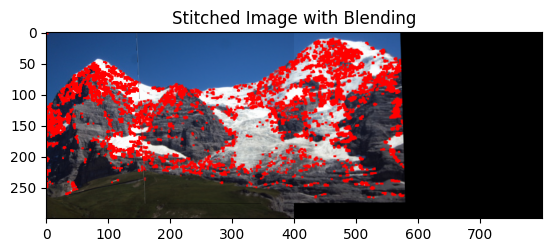

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ensure that img1 and img2 are loaded correctly as BGR images

# Create SIFT feature extractor
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Match descriptors using KNN
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Proceed only if we have enough good matches
min_match_count = 4

if len(good_matches) >= min_match_count:
    # Extract location of good matches
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches ]).reshape(-1, 1, 2)

    # Find homography using RANSAC
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Create a result canvas that is large enough to hold both images initially
    canvas_width = img1.shape[1] + img2.shape[1]
    canvas_height = max(img1.shape[0], img2.shape[0])
    result = np.zeros((canvas_height, canvas_width, 3), dtype=img1.dtype)

    # Place img1 on the canvas
    result[0:img1.shape[0], 0:img1.shape[1]] = img1
    inv_h =np.linalg.inv(H)
    # Warp img2 using the homography matrix 'H'
    warped_img2 = cv2.warpPerspective(img2, inv_h, (canvas_width, canvas_height))

    # Create a mask from the warped img2 by finding all non-zero pixels
    mask_warped_img2 = np.any(warped_img2 != [0, 0, 0], axis=-1)

    # Blend the warped img2 onto the canvas where it should go
    mask_blend = np.logical_and(mask_warped_img2, np.logical_not(np.any(result != [0, 0, 0], axis=-1)))
    result[mask_blend] = warped_img2[mask_blend]

    # Where there's overlap, blend the images using averaging
    mask_overlap = np.logical_and(mask_warped_img2, np.any(result != [0, 0, 0], axis=-1))
    result[mask_overlap] = (result[mask_overlap].astype(np.float32) + warped_img2[mask_overlap].astype(np.float32)) / 2

    # Convert the result to RGB for proper display with matplotlib
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Stitched Image with Blending')
    plt.show()
else:
    print(f"Not enough matches are found - {len(good_matches)}/{min_match_count}")
    # Handle the failure case appropriately